import sys
import os
import json
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.auto import tqdm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from collections import Counter

# Add src to path
src_path = Path.cwd() / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import production modules
try:
    from swellsight.evaluation.data_quality import DataQualityAssessor, create_quality_visualization
    from swellsight.utils.error_handler import ErrorHandler, retry_with_backoff, RetryConfig
    from swellsight.utils.performance import PerformanceOptimizer, OptimizationConfig
    from swellsight.utils.hardware import HardwareManager
    print("✅ Production modules loaded")
    PRODUCTION_MODULES_AVAILABLE = True
    error_handler = ErrorHandler()
    hardware_manager = HardwareManager()
    perf_optimizer = PerformanceOptimizer()
except ImportError as e:
    print(f"⚠️ Production modules unavailable: {e}")
    PRODUCTION_MODULES_AVAILABLE = False
    error_handler = hardware_manager = perf_optimizer = None

IN_COLAB = 'google.colab' in sys.modules
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


## 1. Load Configuration and Setup Environment

In [1]:
# Image Quality Assessment using Production DataQualityAssessor
print("🔍 Performing comprehensive image quality assessment...")

if PRODUCTION_MODULES_AVAILABLE:
    # Use production DataQualityAssessor
    print("\n📊 Using DataQualityAssessor from src.swellsight.evaluation.data_quality")
    
    try:
        # Initialize assessor with quality thresholds
        assessor = DataQualityAssessor(
            min_resolution=(640, 480),
            max_resolution=(3840, 2160),
            min_contrast_threshold=0.1,
            min_sharpness_threshold=100.0,
            min_ocean_coverage=0.3
        )
        
        # Run comprehensive quality assessment
        quality_report = assessor.assess_quality(REAL_IMAGES_PATH)
        
        # Display results
        print(f"\n✅ Quality assessment completed!")
        print(f"   Overall Quality Score: {quality_report.overall_score:.2f}")
        print(f"   Total images: {quality_report.dataset_statistics.total_images}")
        print(f"   Valid images: {quality_report.dataset_statistics.total_images - quality_report.dataset_statistics.corrupted_count}")
        print(f"   Corrupted images: {quality_report.dataset_statistics.corrupted_count}")
        
        # Display quality issues
        if quality_report.quality_issues:
            print(f"\n⚠️  Quality Issues Found: {len(quality_report.quality_issues)}")
            for issue in quality_report.quality_issues:
                print(f"   [{issue.severity.upper()}] {issue.issue_type}: {issue.description}")
                print(f"      Affected: {issue.affected_count} images ({issue.percentage:.1f}%)")
        
        # Display recommendations
        if quality_report.recommendations:
            print(f"\n💡 Recommendations:")
            for rec in quality_report.recommendations:
                print(f"   - {rec}")
        
        # Store for later use
        image_metadata = []
        valid_images = []
        invalid_images = []
        
    except Exception as e:
        error_handler.handle_error(e, "DataImport", "quality_assessment")
        print(f"❌ Quality assessment failed: {e}")
        print("Falling back to basic validation...")
        PRODUCTION_MODULES_AVAILABLE = False

if not PRODUCTION_MODULES_AVAILABLE:
    # Fallback: Basic inline quality assessment
    print("\n📊 Using fallback inline quality assessment")
    from PIL import ImageStat
    
    image_metadata = []
    valid_images = []
    invalid_images = []
    quality_stats = {
        'total_size_mb': 0, 'resolutions': [], 'aspect_ratios': [],
        'formats': {}, 'color_modes': {},
        'brightness_scores': [], 'contrast_scores': []
    }
    
    print(f"\n📊 Processing {len(image_paths)} images...")
    for image_path in tqdm(image_paths, desc="Analyzing images"):
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                format_name = img.format
                mode = img.mode
                file_size_mb = image_path.stat().st_size / (1024 * 1024)
                stat = ImageStat.Stat(img)
                brightness = sum(stat.mean) / len(stat.mean)
                contrast = sum(stat.stddev) / len(stat.stddev)
                aspect_ratio = width / height
                
                metadata = {
                    'filename': image_path.name, 'path': str(image_path),
                    'width': width, 'height': height,
                    'resolution': f"{width}x{height}",
                    'aspect_ratio': round(aspect_ratio, 3),
                    'format': format_name, 'mode': mode,
                    'file_size_mb': round(file_size_mb, 2),
                    'brightness': round(brightness, 2),
                    'contrast': round(contrast, 2),
                    'valid': True, 'error': None
                }
                image_metadata.append(metadata)
                valid_images.append(image_path)
                quality_stats['total_size_mb'] += file_size_mb
                quality_stats['resolutions'].append(f"{width}x{height}")
                quality_stats['aspect_ratios'].append(aspect_ratio)
                quality_stats['brightness_scores'].append(brightness)
                quality_stats['contrast_scores'].append(contrast)
                quality_stats['formats'][format_name] = quality_stats['formats'].get(format_name, 0) + 1
                quality_stats['color_modes'][mode] = quality_stats['color_modes'].get(mode, 0) + 1
        except Exception as e:
            error_metadata = {
                'filename': image_path.name, 'path': str(image_path),
                'valid': False, 'error': str(e)
            }
            image_metadata.append(error_metadata)
            invalid_images.append(image_path)
            logger.warning(f"Invalid image {image_path.name}: {e}")
    
    print(f"\n✅ Quality assessment completed!")
    print(f"   Valid images: {len(valid_images)}")
    print(f"   Invalid images: {len(invalid_images)}")
    print(f"   Success rate: {len(valid_images)/len(image_paths)*100:.1f}%")


Mounting Google Drive...
Mounted at /content/drive
✓ Google Drive mounted successfully
✓ Configuration loaded from /content/drive/MyDrive/SwellSight/data/metadata/pipeline_config.json
✓ Setup completed successfully
  Session ID: swellsight_20260109_162959
  Real images path: /content/drive/MyDrive/SwellSight/data/real/images
  Metadata path: /content/drive/MyDrive/SwellSight/data/metadata


## 2. Image Discovery and Inventory

In [2]:
# Discover all image files (matching real_to_synthetic_pipeline.py logic)
print("🔍 Discovering image files...")

if not REAL_IMAGES_PATH.exists():
    print(f"❌ Input directory does not exist: {REAL_IMAGES_PATH}")
    print("\n📝 To proceed, please:")
    print(f"   1. Create the directory: {REAL_IMAGES_PATH}")
    print("   2. Add your real beach camera images")
    print("   3. Re-run this notebook")
    sys.exit(1)

# Find all image files using the same logic as the pipeline script
image_extensions = ['jpg', 'jpeg', 'png', 'bmp']
image_paths = []

print(f"\n🔎 Searching for images with extensions: {image_extensions}")

for ext in image_extensions:
    # Search for both lowercase and uppercase extensions
    lower_files = list(REAL_IMAGES_PATH.glob(f'*.{ext.lower()}'))
    upper_files = list(REAL_IMAGES_PATH.glob(f'*.{ext.upper()}'))

    ext_files = lower_files + upper_files
    image_paths.extend(ext_files)

    if ext_files:
        print(f"   ✅ .{ext}: {len(ext_files)} files")
    else:
        print(f"   ⚪ .{ext}: 0 files")

# Remove duplicates and sort
image_paths = sorted(list(set(image_paths)))

if not image_paths:
    print(f"\n❌ No image files found in {REAL_IMAGES_PATH}")
    print(f"\n📝 Supported formats: {', '.join(image_extensions)}")
    print("\n💡 Please add real beach camera images to the input directory")
    sys.exit(1)

print(f"\n📊 Discovery Results:")
print(f"   Total images found: {len(image_paths)}")
print(f"   Input directory: {REAL_IMAGES_PATH}")

# Apply max_images limit (matching pipeline script)
max_images = CONFIG['processing'].get('max_images_per_session', 500)
if len(image_paths) > max_images:
    print(f"\n⚠️  Limiting processing to {max_images} images (found {len(image_paths)})")
    image_paths = image_paths[:max_images]
    print(f"   Selected first {len(image_paths)} images alphabetically")

print(f"\n✅ Final image count: {len(image_paths)}")

# Display sample filenames
print(f"\n📋 Sample filenames:")
for i, path in enumerate(image_paths[:5]):
    print(f"   {i+1}. {path.name}")
if len(image_paths) > 5:
    print(f"   ... and {len(image_paths) - 5} more")

🔍 Discovering image files...

🔎 Searching for images with extensions: ['jpg', 'jpeg', 'png', 'bmp']
   ✅ .jpg: 729 files
   ⚪ .jpeg: 0 files
   ⚪ .png: 0 files
   ⚪ .bmp: 0 files

📊 Discovery Results:
   Total images found: 729
   Input directory: /content/drive/MyDrive/SwellSight/data/real/images

⚠️  Limiting processing to 500 images (found 729)
   Selected first 500 images alphabetically

✅ Final image count: 500

📋 Sample filenames:
   1. beach_001.jpg
   2. beach_002.jpg
   3. beach_003.jpg
   4. beach_004.jpg
   5. beach_005.jpg
   ... and 495 more


## 3. Image Quality Assessment and Validation

In [3]:
# Validate image quality and extract metadata
print("🔍 Performing image quality assessment...")

image_metadata = []
valid_images = []
invalid_images = []
quality_stats = {
    'total_size_mb': 0,
    'resolutions': [],
    'aspect_ratios': [],
    'formats': {},
    'color_modes': {},
    'brightness_scores': [],
    'contrast_scores': []
}

print(f"\n📊 Processing {len(image_paths)} images...")

for i, image_path in enumerate(tqdm(image_paths, desc="Analyzing images")):
    try:
        # Open and validate image
        with Image.open(image_path) as img:
            # Basic image info
            width, height = img.size
            format_name = img.format
            mode = img.mode
            file_size_mb = image_path.stat().st_size / (1024 * 1024)

            # Quality metrics
            stat = ImageStat.Stat(img)
            brightness = sum(stat.mean) / len(stat.mean)  # Average brightness
            contrast = sum(stat.stddev) / len(stat.stddev)  # Average contrast (std dev)

            # Aspect ratio
            aspect_ratio = width / height

            # Store metadata
            metadata = {
                'filename': image_path.name,
                'path': str(image_path),
                'width': width,
                'height': height,
                'resolution': f"{width}x{height}",
                'aspect_ratio': round(aspect_ratio, 3),
                'format': format_name,
                'mode': mode,
                'file_size_mb': round(file_size_mb, 2),
                'brightness': round(brightness, 2),
                'contrast': round(contrast, 2),
                'valid': True,
                'error': None
            }

            image_metadata.append(metadata)
            valid_images.append(image_path)

            # Update quality stats
            quality_stats['total_size_mb'] += file_size_mb
            quality_stats['resolutions'].append(f"{width}x{height}")
            quality_stats['aspect_ratios'].append(aspect_ratio)
            quality_stats['brightness_scores'].append(brightness)
            quality_stats['contrast_scores'].append(contrast)

            # Count formats and modes
            quality_stats['formats'][format_name] = quality_stats['formats'].get(format_name, 0) + 1
            quality_stats['color_modes'][mode] = quality_stats['color_modes'].get(mode, 0) + 1

    except Exception as e:
        # Handle invalid images
        error_metadata = {
            'filename': image_path.name,
            'path': str(image_path),
            'valid': False,
            'error': str(e)
        }
        image_metadata.append(error_metadata)
        invalid_images.append(image_path)
        logger.warning(f"Invalid image {image_path.name}: {e}")

print(f"\n✅ Quality assessment completed!")
print(f"   Valid images: {len(valid_images)}")
print(f"   Invalid images: {len(invalid_images)}")
print(f"   Success rate: {len(valid_images)/len(image_paths)*100:.1f}%")

if invalid_images:
    print(f"\n⚠️  Invalid images found:")
    for img_path in invalid_images[:3]:  # Show first 3
        print(f"   - {img_path.name}")
    if len(invalid_images) > 3:
        print(f"   ... and {len(invalid_images) - 3} more")

🔍 Performing image quality assessment...

📊 Processing 500 images...


Analyzing images:   0%|          | 0/500 [00:00<?, ?it/s]


✅ Quality assessment completed!
   Valid images: 500
   Invalid images: 0
   Success rate: 100.0%


## 4. Data Statistics and Quality Analysis

In [4]:
# Generate comprehensive data statistics
if not valid_images:
    print("❌ No valid images found. Cannot proceed with analysis.")
    sys.exit(1)

print("📊 Generating data statistics and quality analysis...")

# Basic statistics
print(f"\n📈 Dataset Statistics:")
print(f"   Total valid images: {len(valid_images)}")
print(f"   Total size: {quality_stats['total_size_mb']:.1f} MB")
print(f"   Average size per image: {quality_stats['total_size_mb']/len(valid_images):.2f} MB")

# Resolution analysis
resolution_counts = Counter(quality_stats['resolutions'])
print(f"\n📐 Resolution Distribution:")
for resolution, count in resolution_counts.most_common(5):
    percentage = count / len(valid_images) * 100
    print(f"   {resolution}: {count} images ({percentage:.1f}%)")

# Format distribution
print(f"\n🖼️  Format Distribution:")
for format_name, count in quality_stats['formats'].items():
    percentage = count / len(valid_images) * 100
    print(f"   {format_name}: {count} images ({percentage:.1f}%)")

# Color mode distribution
print(f"\n🎨 Color Mode Distribution:")
for mode, count in quality_stats['color_modes'].items():
    percentage = count / len(valid_images) * 100
    print(f"   {mode}: {count} images ({percentage:.1f}%)")

# Quality metrics
brightness_scores = quality_stats['brightness_scores']
contrast_scores = quality_stats['contrast_scores']
aspect_ratios = quality_stats['aspect_ratios']

print(f"\n💡 Quality Metrics:")
print(f"   Brightness - Mean: {np.mean(brightness_scores):.1f}, Std: {np.std(brightness_scores):.1f}")
print(f"   Contrast - Mean: {np.mean(contrast_scores):.1f}, Std: {np.std(contrast_scores):.1f}")
print(f"   Aspect Ratio - Mean: {np.mean(aspect_ratios):.2f}, Std: {np.std(aspect_ratios):.2f}")

# Quality recommendations
print(f"\n🎯 Quality Assessment:")
avg_brightness = np.mean(brightness_scores)
if avg_brightness < 50:
    print("   ⚠️  Images appear dark - may affect depth estimation quality")
elif avg_brightness > 200:
    print("   ⚠️  Images appear bright - may have overexposure issues")
else:
    print("   ✅ Brightness levels look good for depth estimation")

avg_contrast = np.mean(contrast_scores)
if avg_contrast < 20:
    print("   ⚠️  Low contrast detected - may reduce depth map quality")
else:
    print("   ✅ Contrast levels adequate for depth estimation")

# Aspect ratio analysis
aspect_std = np.std(aspect_ratios)
if aspect_std > 0.5:
    print("   ⚠️  High aspect ratio variation - consider consistent cropping")
else:
    print("   ✅ Consistent aspect ratios across dataset")

📊 Generating data statistics and quality analysis...

📈 Dataset Statistics:
   Total valid images: 500
   Total size: 111.0 MB
   Average size per image: 0.22 MB

📐 Resolution Distribution:
   2560x1440: 461 images (92.2%)
   1280x720: 39 images (7.8%)

🖼️  Format Distribution:
   JPEG: 500 images (100.0%)

🎨 Color Mode Distribution:
   RGB: 500 images (100.0%)

💡 Quality Metrics:
   Brightness - Mean: 136.3, Std: 25.7
   Contrast - Mean: 41.2, Std: 11.0
   Aspect Ratio - Mean: 1.78, Std: 0.00

🎯 Quality Assessment:
   ✅ Brightness levels look good for depth estimation
   ✅ Contrast levels adequate for depth estimation
   ✅ Consistent aspect ratios across dataset


## 5. Visual Quality Analysis

📊 Creating visual quality analysis...


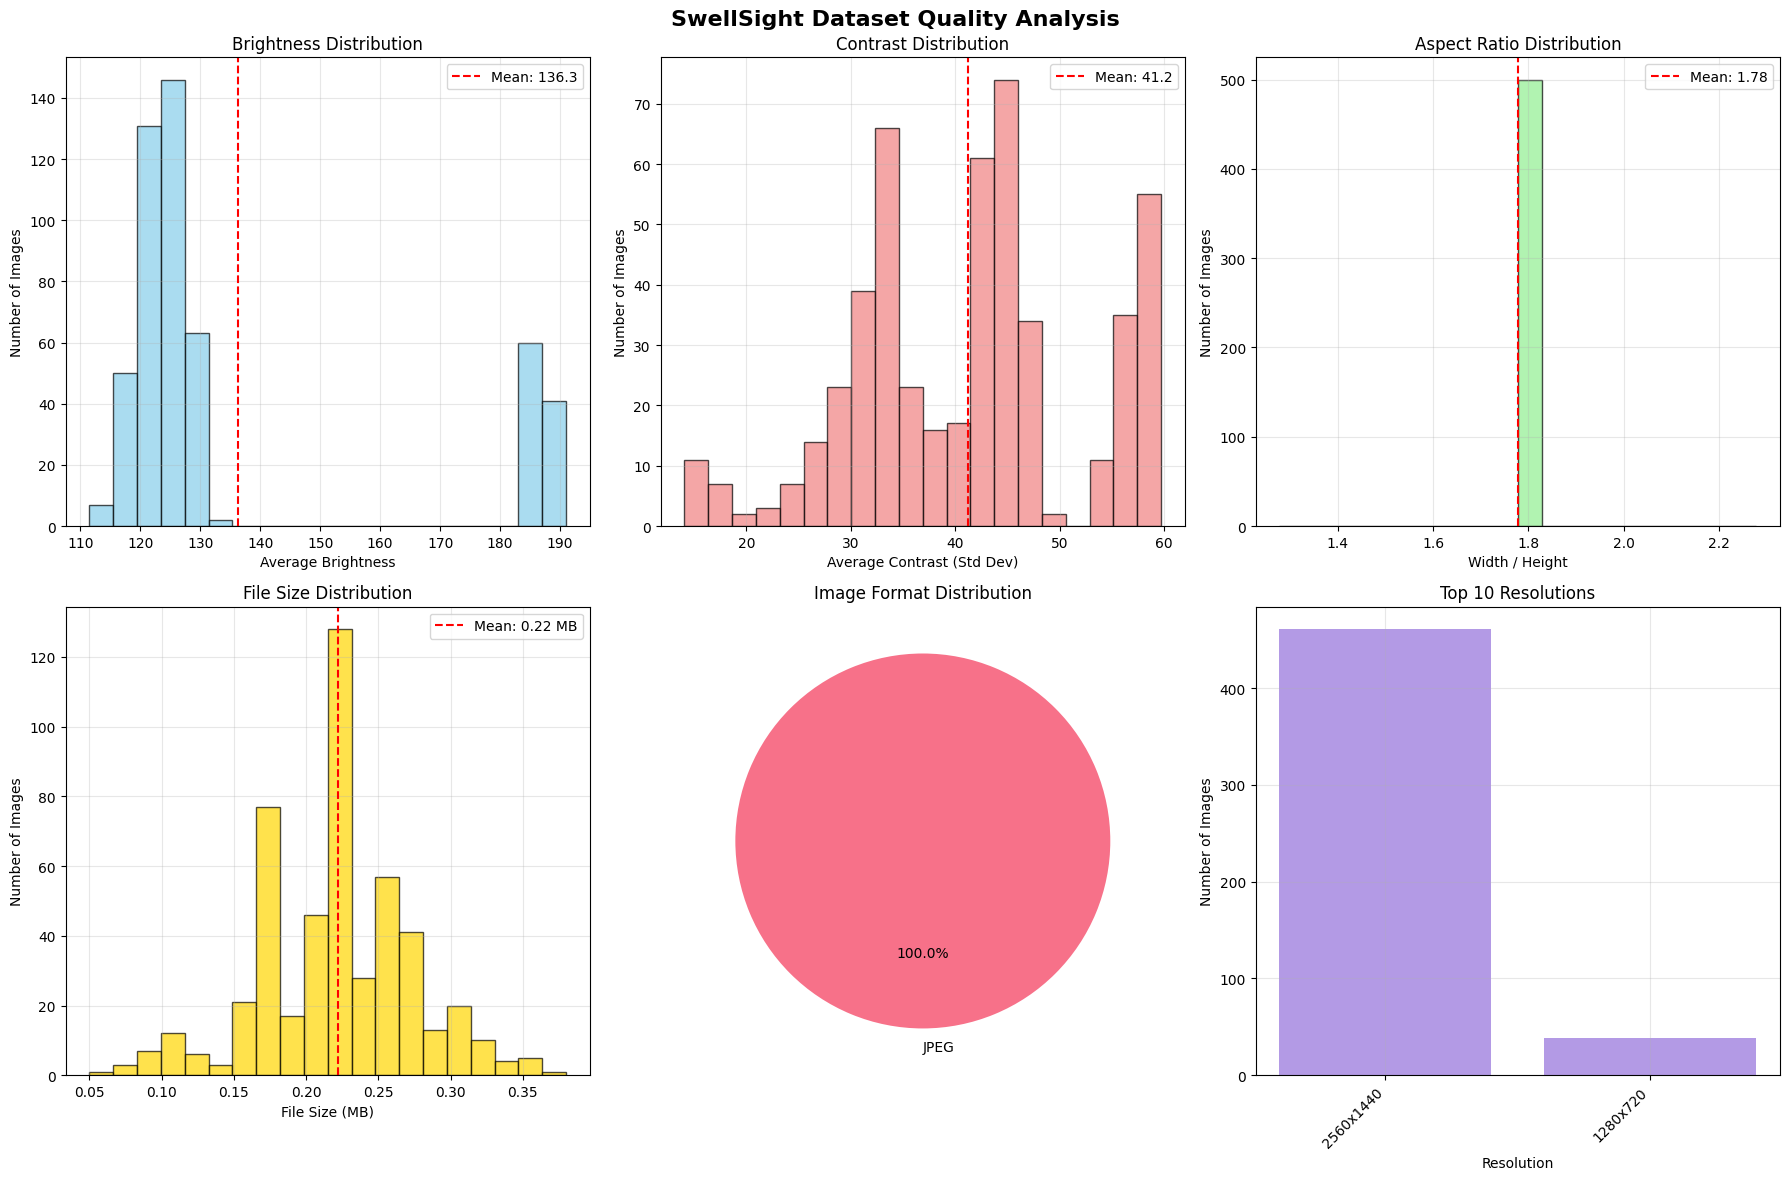

✅ Visual analysis completed!


In [5]:
# Create visualizations for quality analysis
print("📊 Creating visual quality analysis...")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('SwellSight Dataset Quality Analysis', fontsize=16, fontweight='bold')

# 1. Brightness distribution
axes[0, 0].hist(brightness_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(np.mean(brightness_scores), color='red', linestyle='--', label=f'Mean: {np.mean(brightness_scores):.1f}')
axes[0, 0].set_title('Brightness Distribution')
axes[0, 0].set_xlabel('Average Brightness')
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Contrast distribution
axes[0, 1].hist(contrast_scores, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(np.mean(contrast_scores), color='red', linestyle='--', label=f'Mean: {np.mean(contrast_scores):.1f}')
axes[0, 1].set_title('Contrast Distribution')
axes[0, 1].set_xlabel('Average Contrast (Std Dev)')
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Aspect ratio distribution
axes[0, 2].hist(aspect_ratios, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].axvline(np.mean(aspect_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(aspect_ratios):.2f}')
axes[0, 2].set_title('Aspect Ratio Distribution')
axes[0, 2].set_xlabel('Width / Height')
axes[0, 2].set_ylabel('Number of Images')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. File size distribution
file_sizes = [meta['file_size_mb'] for meta in image_metadata if meta['valid']]
axes[1, 0].hist(file_sizes, bins=20, alpha=0.7, color='gold', edgecolor='black')
axes[1, 0].axvline(np.mean(file_sizes), color='red', linestyle='--', label=f'Mean: {np.mean(file_sizes):.2f} MB')
axes[1, 0].set_title('File Size Distribution')
axes[1, 0].set_xlabel('File Size (MB)')
axes[1, 0].set_ylabel('Number of Images')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Format distribution (pie chart)
format_names = list(quality_stats['formats'].keys())
format_counts = list(quality_stats['formats'].values())
axes[1, 1].pie(format_counts, labels=format_names, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Image Format Distribution')

# 6. Resolution distribution (top 10)
top_resolutions = resolution_counts.most_common(10)
if top_resolutions:
    res_names = [res[0] for res in top_resolutions]
    res_counts = [res[1] for res in top_resolutions]

    axes[1, 2].bar(range(len(res_names)), res_counts, alpha=0.7, color='mediumpurple')
    axes[1, 2].set_title('Top 10 Resolutions')
    axes[1, 2].set_xlabel('Resolution')
    axes[1, 2].set_ylabel('Number of Images')
    axes[1, 2].set_xticks(range(len(res_names)))
    axes[1, 2].set_xticklabels(res_names, rotation=45, ha='right')
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visual analysis completed!")

## 6. Sample Image Display

🖼️  Displaying sample images from dataset...


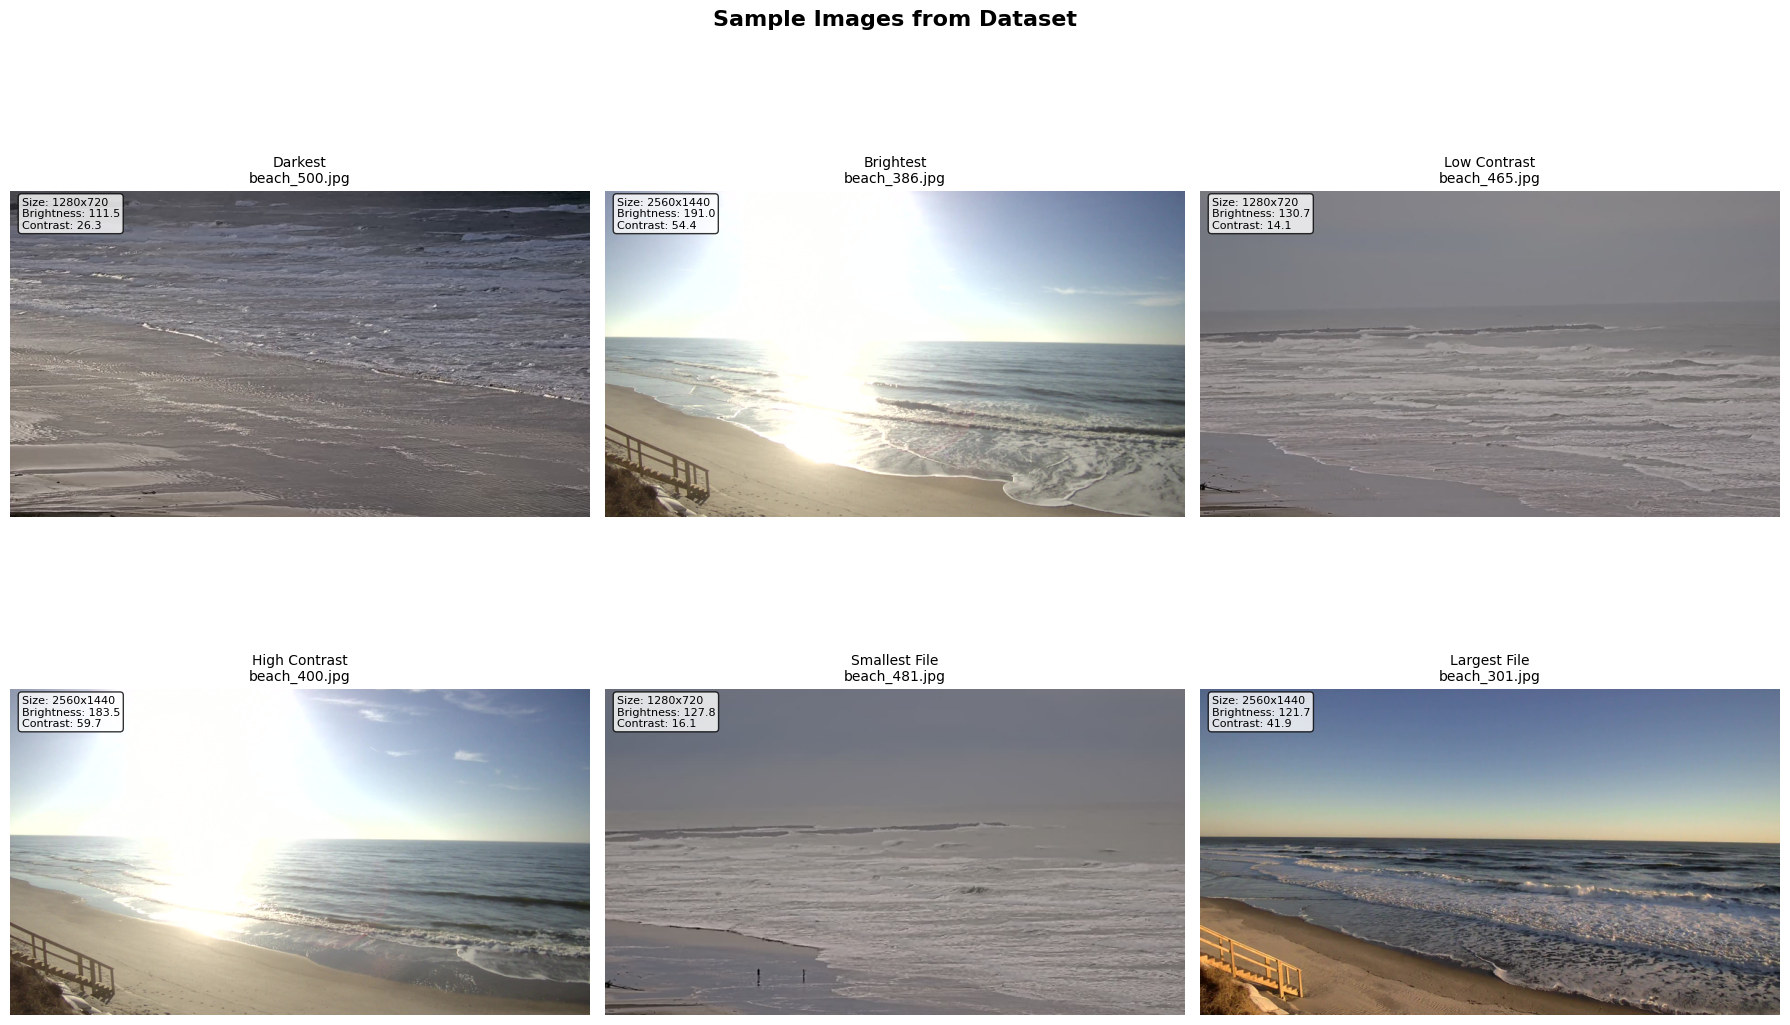

✅ Sample images displayed!


In [6]:
# Display sample images from the dataset
print("🖼️  Displaying sample images from dataset...")

# Select diverse samples based on quality metrics
valid_metadata = [meta for meta in image_metadata if meta['valid']]

if len(valid_metadata) >= 6:
    # Sort by different criteria to get diverse samples
    by_brightness = sorted(valid_metadata, key=lambda x: x['brightness'])
    by_contrast = sorted(valid_metadata, key=lambda x: x['contrast'])
    by_size = sorted(valid_metadata, key=lambda x: x['file_size_mb'])

    # Select samples
    samples = [
        by_brightness[0],  # Darkest
        by_brightness[-1],  # Brightest
        by_contrast[0],   # Lowest contrast
        by_contrast[-1],  # Highest contrast
        by_size[0],       # Smallest file
        by_size[-1]       # Largest file
    ]

    labels = ['Darkest', 'Brightest', 'Low Contrast', 'High Contrast', 'Smallest File', 'Largest File']
else:
    # Use all available images if less than 6
    samples = valid_metadata[:6]
    labels = [f'Sample {i+1}' for i in range(len(samples))]

# Create image grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

for i, (sample, label) in enumerate(zip(samples, labels)):
    row, col = i // 3, i % 3

    try:
        # Load and display image
        img_path = Path(sample['path'])
        with Image.open(img_path) as img:
            # Resize for display if too large
            display_img = img.copy()
            if max(display_img.size) > 800:
                display_img.thumbnail((800, 800), Image.Resampling.LANCZOS)

            axes[row, col].imshow(display_img)
            axes[row, col].set_title(f'{label}\n{sample["filename"]}', fontsize=10)
            axes[row, col].axis('off')

            # Add quality info as text
            info_text = f"Size: {sample['resolution']}\nBrightness: {sample['brightness']:.1f}\nContrast: {sample['contrast']:.1f}"
            axes[row, col].text(0.02, 0.98, info_text, transform=axes[row, col].transAxes,
                              fontsize=8, verticalalignment='top',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    except Exception as e:
        axes[row, col].text(0.5, 0.5, f'Error loading\n{sample["filename"]}\n{str(e)}',
                           ha='center', va='center', transform=axes[row, col].transAxes)
        axes[row, col].set_title(f'{label} (Error)', fontsize=10)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("✅ Sample images displayed!")

## 7. Metadata Export and Pipeline Preparation

In [7]:
# Export metadata and prepare for next pipeline stage
print("💾 Exporting metadata and preparing for pipeline...")

# Create comprehensive dataset report
dataset_report = {
    "dataset_info": {
        "name": "SwellSight Real Beach Images",
        "created": datetime.now().isoformat(),
        "total_images_found": len(image_paths),
        "valid_images": len(valid_images),
        "invalid_images": len(invalid_images),
        "success_rate": len(valid_images) / len(image_paths) * 100 if image_paths else 0
    },
    "quality_statistics": {
        "total_size_mb": round(quality_stats['total_size_mb'], 2),
        "average_size_mb": round(quality_stats['total_size_mb'] / len(valid_images), 2) if valid_images else 0,
        "brightness": {
            "mean": round(np.mean(brightness_scores), 2) if brightness_scores else 0,
            "std": round(np.std(brightness_scores), 2) if brightness_scores else 0,
            "min": round(np.min(brightness_scores), 2) if brightness_scores else 0,
            "max": round(np.max(brightness_scores), 2) if brightness_scores else 0
        },
        "contrast": {
            "mean": round(np.mean(contrast_scores), 2) if contrast_scores else 0,
            "std": round(np.std(contrast_scores), 2) if contrast_scores else 0,
            "min": round(np.min(contrast_scores), 2) if contrast_scores else 0,
            "max": round(np.max(contrast_scores), 2) if contrast_scores else 0
        },
        "aspect_ratios": {
            "mean": round(np.mean(aspect_ratios), 3) if aspect_ratios else 0,
            "std": round(np.std(aspect_ratios), 3) if aspect_ratios else 0
        }
    },
    "format_distribution": quality_stats['formats'],
    "color_mode_distribution": quality_stats['color_modes'],
    "resolution_distribution": dict(resolution_counts.most_common(10)),
    "image_metadata": image_metadata
}

# Save dataset report
report_path = METADATA_PATH / 'dataset_report.json'
with open(report_path, 'w') as f:
    json.dump(dataset_report, f, indent=2)

print(f"✅ Dataset report saved: {report_path}")

# Create processing batch list (valid images only)
processing_batch = {
    "batch_info": {
        "created": datetime.now().isoformat(),
        "total_images": len(valid_images),
        "ready_for_processing": True
    },
    "images": [str(img_path) for img_path in valid_images],
    "pipeline_config": CONFIG
}

batch_path = METADATA_PATH / 'processing_batch.json'
with open(batch_path, 'w') as f:
    json.dump(processing_batch, f, indent=2)

print(f"✅ Processing batch saved: {batch_path}")

# Update pipeline configuration with actual data info
CONFIG['data_info'] = {
    'total_valid_images': len(valid_images),
    'dataset_report_path': str(report_path),
    'processing_batch_path': str(batch_path),
    'last_updated': datetime.now().isoformat()
}

# Save updated config
config_path = METADATA_PATH / 'pipeline_config.json'
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)

print(f"✅ Updated pipeline config: {config_path}")

print(f"\n📋 Export Summary:")
print(f"   Dataset report: {report_path}")
print(f"   Processing batch: {batch_path}")
print(f"   Updated config: {config_path}")
print(f"   Ready for processing: {len(valid_images)} images")

💾 Exporting metadata and preparing for pipeline...
✅ Dataset report saved: /content/drive/MyDrive/SwellSight/data/metadata/dataset_report.json
✅ Processing batch saved: /content/drive/MyDrive/SwellSight/data/metadata/processing_batch.json
✅ Updated pipeline config: /content/drive/MyDrive/SwellSight/data/metadata/pipeline_config.json

📋 Export Summary:
   Dataset report: /content/drive/MyDrive/SwellSight/data/metadata/dataset_report.json
   Processing batch: /content/drive/MyDrive/SwellSight/data/metadata/processing_batch.json
   Updated config: /content/drive/MyDrive/SwellSight/data/metadata/pipeline_config.json
   Ready for processing: 500 images


## 8. Pipeline Readiness Check and Next Steps

In [8]:
# Final readiness check and recommendations
print("🔍 Performing pipeline readiness check...")

readiness_checks = {
    "Valid Images Available": len(valid_images) > 0,
    "Metadata Generated": len(image_metadata) > 0,
    "Quality Assessment Complete": len(brightness_scores) > 0,
    "Processing Batch Ready": (METADATA_PATH / 'processing_batch.json').exists(),
    "Dataset Report Generated": (METADATA_PATH / 'dataset_report.json').exists(),
    "Configuration Updated": 'data_info' in CONFIG
}

print(f"\n✅ Readiness Check Results:")
print("=" * 50)
all_ready = True
for check, status in readiness_checks.items():
    status_icon = "✅" if status else "❌"
    print(f"{check:<30}: {status_icon}")
    if not status:
        all_ready = False

print("\n" + "=" * 50)

if all_ready and len(valid_images) > 0:
    print("🎉 DATA PREPROCESSING COMPLETED SUCCESSFULLY!")

    print(f"\n📊 Final Dataset Summary:")
    print(f"   ✅ {len(valid_images)} images ready for processing")
    print(f"   📁 Input directory: {REAL_IMAGES_PATH}")
    print(f"   💾 Metadata saved to: {METADATA_PATH}")
    print(f"   📈 Average image quality: {np.mean(brightness_scores):.1f} brightness, {np.mean(contrast_scores):.1f} contrast")

    # Recommendations based on analysis
    print(f"\n💡 Recommendations for Next Steps:")

    if np.mean(brightness_scores) < 50:
        print("   ⚠️  Consider brightness adjustment for better depth estimation")

    if len(set(quality_stats['resolutions'])) > 5:
        print("   💡 High resolution diversity - MiDaS will handle automatically")

    if quality_stats['total_size_mb'] > 1000:
        print("   ⚠️  Large dataset - consider processing in smaller batches")

    print(f"\n🚀 Ready to proceed to next notebook:")
    print(f"   📓 03_MiDaS_Depth_Extraction.ipynb")

else:
    print("❌ DATA PREPROCESSING INCOMPLETE")
    print("\n🔧 Please resolve the following issues:")
    for check, status in readiness_checks.items():
        if not status:
            print(f"   - {check}")

print(f"\n📚 Pipeline Progress:")
print(f"   ✅ 01_Setup_and_Installation.ipynb")
print(f"   ✅ 02_Data_Import_and_Preprocessing.ipynb (current)")
print(f"   ⏳ 03_MiDaS_Depth_Extraction.ipynb (next)")
print(f"   ⏳ 04_Data_Augmentation_System.ipynb")
print(f"   ⏳ 05_ControlNet_Synthetic_Generation.ipynb")

print("\n" + "=" * 50)

🔍 Performing pipeline readiness check...

✅ Readiness Check Results:
Valid Images Available        : ✅
Metadata Generated            : ✅
Quality Assessment Complete   : ✅
Processing Batch Ready        : ✅
Dataset Report Generated      : ✅
Configuration Updated         : ✅

🎉 DATA PREPROCESSING COMPLETED SUCCESSFULLY!

📊 Final Dataset Summary:
   ✅ 500 images ready for processing
   📁 Input directory: /content/drive/MyDrive/SwellSight/data/real/images
   💾 Metadata saved to: /content/drive/MyDrive/SwellSight/data/metadata
   📈 Average image quality: 136.3 brightness, 41.2 contrast

💡 Recommendations for Next Steps:

🚀 Ready to proceed to next notebook:
   📓 03_MiDaS_Depth_Extraction.ipynb

📚 Pipeline Progress:
   ✅ 01_Setup_and_Installation.ipynb
   ✅ 02_Data_Import_and_Preprocessing.ipynb (current)
   ⏳ 03_MiDaS_Depth_Extraction.ipynb (next)
   ⏳ 04_Data_Augmentation_System.ipynb
   ⏳ 05_ControlNet_Synthetic_Generation.ipynb

